In [ ]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from collections import deque
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, concatenate, Add

from keras.optimizers import Adam, RMSprop
from keras import backend as K
from IPython.display import clear_output
from IPython.display import Image
import imageio
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Classes and functions

In [ ]:
lose_reward = -2.5
win_reward = 2.5
yolo_reward = 0.1
rep_point_reward = -0.5
open_point_reward = 2.2

In [ ]:
class Minesweeper(object):

  '''
  Class of minesweeper game
  Input parameters:
    - mines_count - number of mines on playfield
    - playfield_size - length of square playfield side
  '''

  def __init__(self, mines_count, playfield_h, playfield_w):
    self.mines_count = mines_count
    self.playfield_h = playfield_h
    self.playfield_w = playfield_w
    # Actions for locate all points around current point (clockwise)
    self.actions = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
    # Field with information about the number of participation of each cell in the prediction
    self.dev_field = np.zeros((self.playfield_h, self.playfield_w))
    # Field with accumulation all predictions value
    self.prediction_field = np.zeros((self.playfield_h, self.playfield_w))
    self.lose_reward = lose_reward
    self.win_reward = win_reward
    self.yolo_reward = yolo_reward
    self.rep_point_reward = rep_point_reward
    self.open_point_reward = open_point_reward

  # Create fake playfield
  def _create_playground(self):
    self.playground = np.zeros((self.playfield_h+2,self. playfield_w+2))
    return self.playground

  # Create filed for mines placement
  def _create_minesfield(self):
    self.minesfield = np.full((self.playfield_h, self.playfield_w), 9)
    return self.minesfield

  # First step coordinates
  def _first_step(self):
    x = np.random.randint(0, self.playfield_h)
    y = np.random.randint(0, self.playfield_w)
    return (x, y)

  # Create mines in random places exept first_step_coord
  def _place_mines(self):
    first_step_coord = self._first_step()

    first_point_surround = []
    for act in self.actions:
      x1 = first_step_coord[0] + act[0]
      y1 = first_step_coord[1] + act[1]
      first_point_surround.append((x1, y1))

    self.mines_coord = []
    while len(self.mines_coord) < self.mines_count:
      x = np.random.randint(0, self.playfield_h)
      y = np.random.randint(0, self.playfield_w)

      if ((x, y) != first_step_coord) and ((x, y) not in self.mines_coord) and ((x, y) not in first_point_surround):
        self.mines_coord.append((x, y))

    return first_step_coord

  # Create stealth playfield with mines around count
  def _mines_number(self):
    mines_round =[]
    for mine in self.mines_coord:
      mines_round.append((mine[0]+1, mine[1]+1))

    field = np.zeros_like(self.playground)

    for i in range(1, self.playfield_h+1):
      for j in range(1, self.playfield_w+1):
        if (i, j) in mines_round:
          continue
        
        field_round = [(i-1,j-1), (i-1,j), (i-1,j+1),
                       (i,j-1), (i,j), (i,j+1),
                       (i+1,j-1), (i+1,j), (i+1,j+1)]
        mines_count = 0
        for point in field_round:
          mines_count += self.playground[point]
        field[i,j] = mines_count

    return field[1:-1, 1:-1]

  # Create fake playfield where stored info abount point surrunding
  def _create_playfield(self):
    for mine in self.mines_coord:
      x = mine[0] + 1
      y = mine[1] + 1
      self.playground[(x,y)] = 1

    self.fake_playfield = self._mines_number()

  # Check if step has reason (step in near field of open points)
  def _yolo_move(self, action):
    # action - (x,y) coordinate of current step

    for act in self.actions:
      x1 = action[0] + act[0]
      y1 = action[1] + act[1]
      if (x1, y1) in self.free_point:
        return False
    
    return True

  # Check if step has reason (step in near field of open points)
  def _yolo_move_for_fake(self, action, rct):
    # action - (x,y) coordinate of current step in field 5x5
    # rct - x1,y1,x2,y2 coordinates of 5x5 field in minesweeper playfield 
    # (where x1,y1 - coordinates of top left corner, x2,y2 - coordinates of bottom right corner)

    for act in self.actions:
      x1 = action[0] + act[0]
      y1 = action[1] + act[1]
      if (x1, y1) in self.free_point and x1 in range(rct[0], rct[2]) and y1 in range(rct[1], rct[3]):
        return False
    
    return True

  # Open all connected zeros in playfield (for game acceleration)
  def open_zeros(self):
    
    done = True
    scale_reward = 0
    while done:
      k = 0
      for point in self.free_point.copy():
        if self.minesfield[point] == 0:
          
          for act in self.actions:
            x = point[0] + act[0]
            y = point[1] + act[1]
            if x in range(self.playfield_h) and y in range(self.playfield_w):
              if self.minesfield[(x,y)] == 9:
                k = 1
                scale_reward += 1
                self.free_point.add((x,y))
                self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
      if k == 0:
        return scale_reward


  # Initialize field for game
  def initialize_game(self):

    self._create_playground()

    self.free_point = set()
    first_step_coord = self._place_mines()
    self.free_point.add(first_step_coord)

    self._create_playfield()
    self._create_minesfield()
    self.minesfield[first_step_coord] = self.fake_playfield[first_step_coord]


  # Open minesfield point or die 
  def step(self, action):
    # action - (x,y) coordinate of current step

    x = action[0]
    y = action[1]

    # Check if current step coordinates in mines_coord
    if (x,y) in self.mines_coord:
      self.free_point.add((x,y))
      # self.minesfield[(x,y)] = 10
      reward = self.lose_reward
      done = True

    # Check if current step coordinates is already done 
    elif (x,y) in self.free_point:
      reward = self.rep_point_reward
      done = False
      
    else:
      # Add point in set of free points
      self.free_point.add((x,y))
      # Check if current step coordinates is yolo move
      if self._yolo_move((x,y)):
        self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
        reward = self.yolo_reward
        done = False
      else:
        # Check if current step coordinates is last free point (win)
        if len(self.free_point) == int(self.playfield_h*self.playfield_w) - self.mines_count:
          self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
          reward = self.win_reward
          done = True
        else:
        # Check if current step coordinates is not last free point
          self.minesfield[(x,y)] = self.fake_playfield[(x,y)]
          reward = self.open_point_reward
          done = False

    return self.minesfield, reward, done


  # Get reward for fake step in small field (5x5)
  def fake_step(self, action, rct):

    # action - (x,y) coordinate of current step in field 5x5
    # rct - x1,y1,x2,y2 coordinates of 5x5 field in minesweeper playfield 
    # (where x1,y1 - coordinates of top left corner, x2,y2 - coordinates of bottom right corner)

    x = action[0] + rct[0]
    y = action[1] + rct[1]

    # Check if current step coordinates in mines_coord
    if (x,y) in self.mines_coord:
      reward = self.lose_reward
      done = True
    # Check if current step coordinates is already done 
    elif (x,y) in self.free_point:
      reward = self.rep_point_reward
      done = False
      
    else:
      # Check if current step coordinates is yolo move
      if self._yolo_move_for_fake((x,y), rct):
        reward = self.yolo_reward
        done = False
      else:
      # Check if current step coordinates is not last free point
        reward = self.open_point_reward
        done = False

    return reward, done

  #############################################
  # fake_step with yolo at last unopened points
  #############################################

  # # Get reward for fake step in small field (5x5)
  # def fake_step(self, action, rct):

  #   # action - (x,y) coordinate of current step in field 5x5
  #   # rct - x1,y1,x2,y2 coordinates of 5x5 field in minesweeper playfield 
  #   # (where x1,y1 - coordinates of top left corner, x2,y2 - coordinates of bottom right corner)

  #   x = action[0] + rct[0]
  #   y = action[1] + rct[1]

  #   # Check if current step coordinates in mines_coord
  #   if (x,y) in self.mines_coord:
  #     reward = -1
  #     done = True
  #   # Check if current step coordinates is already done 
  #   elif (x,y) in self.free_point:
  #     reward = -0.3
  #     done = False
      
  #   else:
  #     # Check if current step coordinates is yolo move
  #     if self._yolo_move_for_fake((x,y), rct):
  #       # often at last steps yolo move is beneficial
  #       if int(self.playfield_h*self.playfield_w) - self.mines_count - len(self.free_point) <= 3:
  #         reward = 0.9
  #         done = False
  #       else:
  #         reward = -0.3
  #         done = False
  #     else:
  #     # Check if current step coordinates is not last free point
  #       reward = 0.9
  #       done = False

  #   return reward, done

In [ ]:
class Agent(object):

  '''
  Class of agent for play minesweeper
  Input parameters:
    - dicision_field - Size of suqare side for dicision field
    - epsilon - start value of probability of random step selection
  '''

  def __init__(self, dicision_field, epsilon):

    self.load_model = True # Always loading model if it is exist

    self.checkpoint_dir = checkpoint_dir # Path where model is saved

    self.dicision_field = dicision_field # Size of suqare side for dicision field
    self.num_actions = int(self.dicision_field * self.dicision_field) # Number of possible actions
    self.state_size = (self.dicision_field, self.dicision_field, 10)
    
    self.epsilon = epsilon
    self.epsilon_start, self.epsilon_end = 1.0, 0.00 # Parameters for epsilon_decay_step calculation
    self.exploration_steps = 500000 # Parameters for epsilon_decay_step calculation
    self.epsilon_decay_step = (self.epsilon_start - self.epsilon_end) / self.exploration_steps

    self.batch_size = 64 # Batch size for model learning
    self.train_start = 1000 # Minimal memory size for start learning
    self.update_target_rate = 5000 # After each ... steps update target model
    self.discount_factor = 0.0 # Discount factor in Bellman equation
    self.memory = deque(maxlen=40000)  # Number of play situations for learning

    self.model = self.build_model()
    self.target_model = self.build_model()
    self.update_target_model()
    
    self.avg_q_max, self.avg_loss = 0., 0.

    if self.load_model:
      if os.path.exists(os.path.join(self.checkpoint_dir, 'curr_ckpt.h5')) is True:
        self.model.load_weights(os.path.join(self.checkpoint_dir, 'curr_ckpt.h5'))

  def build_model(self):

    input = Input(shape=(self.state_size))

    x1 = Conv2D(32, (5,5), padding='same', activation='tanh')(input)
    x2 = Conv2D(32, (3,3), padding='same', activation='tanh')(input)

    x3 = Conv2D(32, (5,5), padding='same', activation='relu')(input)
    x4 = Conv2D(32, (3,3), padding='same', activation='relu')(input)

    xx = Add()([x1, x2])
    xy = concatenate([xx, x3, x4])
    x = Conv2D(64, (3,3), padding='same', activation='relu')(xy)
    output = Conv2D(1, (3,3), padding='same', activation='linear')(x)

    model = Model(input, output)
    model.compile(optimizer=Adam(lr=0.5e-4),
                  loss='mse')
    
    return model
    

  # Load in target model weigths of current model
  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())

  # Select action
  def get_action(self, history, free_point_set):
    if np.random.rand() <= self.epsilon:
      total_points = set(np.arange(self.num_actions))
      free_points = set([point[0]*self.dicision_field + point[1] for point in free_point_set])
      selection_points = total_points - free_points
      # print(selection_points)
      return int(random.sample(list(selection_points), 1)[0])
    else:
      q_value = self.model.predict(np.expand_dims(history, axis=0))
      return np.argmax(q_value)

  # Select action
  def get_action_low(self, history):
    q_value = self.model.predict(np.expand_dims(history, axis=0))
    return q_value

  # Add play situation in memory
  def replay_memory(self, history, action, reward, done):
    self.memory.append((history, action, reward, done))

  # Train current model on batch
  def train_replay(self):
    if len(self.memory) < self.train_start:
      return
    if self.epsilon > self.epsilon_end:
      self.epsilon -= self.epsilon_decay_step

    mini_batch = random.sample(self.memory, self.batch_size)

    history = np.zeros((self.batch_size, self.state_size[0],
                        self.state_size[1], self.state_size[2]))

    target = np.zeros((self.batch_size))

    action, reward, done = [], [], []

    for i in range(self.batch_size):
      history[i] = np.float32(mini_batch[i][0])
      action.append(mini_batch[i][1])
      reward.append(mini_batch[i][2])
      done.append(mini_batch[i][3])

    q_value = self.model.predict(history)

    for i in range(self.batch_size):
      if done[i]:
        target[i] = reward[i]
      else:
        target[i] = reward[i]

      xi = int(action[i] // self.dicision_field)
      yi = int(action[i] - xi * self.dicision_field)
      q_value[i][xi, yi] = target[i]
    
    loss = self.model.train_on_batch(history, q_value)

    self.avg_loss += loss


  # Train current model on batch
  def train_replay_full(self):
    if len(self.memory) < self.train_start:
      return
    if self.epsilon > self.epsilon_end:
      self.epsilon -= self.epsilon_decay_step

    mini_batch = random.sample(self.memory, self.batch_size)

    history = np.zeros((self.batch_size, self.state_size[0],
                        self.state_size[1], self.state_size[2]))

    # target = np.zeros((self.batch_size))

    action, reward, done = [], [], []

    for i in range(self.batch_size):
      history[i] = np.float32(mini_batch[i][0])
      action.append(mini_batch[i][1])
      reward.append(mini_batch[i][2])
      done.append(mini_batch[i][3])

    q_value = self.model.predict(history)

    for i in range(self.batch_size):
      for j, tg in enumerate(reward[i]):
        # target[i][j] = reward[i][j]

        xi = int(action[i][j] // self.dicision_field)
        yi = int(action[i][j] - xi * self.dicision_field)
        q_value[i][xi, yi] = reward[i][j]
    
    loss = self.model.train_on_batch(history, q_value)

    self.avg_loss += loss

  def save_model(self):
    self.model.save_weights(os.path.join(self.checkpoint_dir, 'curr_ckpt.h5'))

In [ ]:
def train_minesweeper(episodes, episode_start, epsilon, global_step, open_zeros=True, advanced=False, full_field=False):

  '''
  Algorithm for training the agent to play minesweeper
  Input parameters:
    - episodes - number of game episodes for train
    - episode_start - start episode number (for continue training after loading)
    - epsilon - start value of probability of random step selection
    - global_step - number of iterations of agent learning on batch
    - advanced - flag for to open connected zeros on minesweeper field
  '''

  for episode in range(episode_start, episodes):

    ddone = False
    step = 0
    score = 0
    k = 0
    window = dicision_field//2 
    # Update minesweeper
    test_minesweeper.initialize_game()
    # Get first playfiled state
    history_filed = to_categorical(test_minesweeper.minesfield, 10)

    while not ddone:

      step += 1
      avg_q_max = 0
      pred_step = 0 # steps for current situation
      # Update minesweeper dev_field and prediction_field
      test_minesweeper.dev_field = np.zeros((playfield_h, playfield_w, 1))
      test_minesweeper.prediction_field = np.zeros((playfield_h, playfield_w, 1))

      # Scan playfield with dicision field
      for i in range(window, playfield_h-window):
        for j in range(window, playfield_w-window):
          rct = [i-window, j-window, i+(window+1), j+(window+1)]

          pred_step += 1
          global_step += 1
          
          current_field = history_filed[rct[0]:rct[2], rct[1]:rct[3]].copy()

          action = agent.get_action(current_field, test_minesweeper.free_point)

          x = int(action // dicision_field)
          y = int(action - x * dicision_field)

          reward, done = test_minesweeper.fake_step((x,y), rct)
          # Train on batch
          # Take in memory only information valuable fields (9 - not open -> 9*25 not valuable)
          if np.sum(np.argmax(current_field, axis=2)) != 225:
            if full_field:
              agent.replay_memory(current_field, [action], [reward], [done])
              agent.train_replay_full()
            else:
              agent.replay_memory(current_field, action, reward, done)
              agent.train_replay()

          if global_step % agent.update_target_rate == 0:
            agent.update_target_model()
          # Get value for predicted action
          q_val = agent.model.predict(np.expand_dims(current_field, axis=0))[0]
          avg_q_max += np.amax(q_val)
          # Add values in prediction_field and dev_field
          test_minesweeper.prediction_field[rct[0]:rct[2], rct[1]:rct[3]] += q_val
          test_minesweeper.dev_field[rct[0]:rct[2], rct[1]:rct[3]] += np.ones((dicision_field, dicision_field, 1))

      agent.avg_q_max += avg_q_max / pred_step # Count mean avg_q_max value
      test_minesweeper.prediction_field = test_minesweeper.prediction_field / test_minesweeper.dev_field # Count summary prediction_field values

      # Get current step action
      action = np.argmax(test_minesweeper.prediction_field)

      x = int(action // playfield_w)
      y = int(action - x * playfield_w)

      if (x,y) in test_minesweeper.free_point:
        k += 1
        
      # Make step
      history_filed, reward, ddone = test_minesweeper.step((x,y))
      # If need open all connected zeros
      if open_zeros:
        scale_reward = test_minesweeper.open_zeros()
        reward += open_point_reward * scale_reward

      history_filed = to_categorical(history_filed, 10)

      score += reward

      if step > playfield_h*playfield_w or k > 2:
        ddone = True
        reward = lose_reward

      if reward == lose_reward and advanced:
        if full_field:
          total_points = set(np.arange(agent.num_actions))
          free_points = set([point[0]*agent.dicision_field + point[1] for point in test_minesweeper.free_point])
          selection_points = total_points - free_points
          test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])
          actions = []
          rewards = []
          done_history = []
          for action in selection_points:
            actions.append(action)
            x = int(action // dicision_field)
            y = int(action - x * dicision_field)
            observe, reward, done = test_minesweeper.step((x,y))
            rewards.append(reward)
            done_history.append(done)
            test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])

          agent.replay_memory(current_field, actions, rewards, done_history)
          agent.train_replay_full()

        else:
          total_points = set(np.arange(agent.num_actions))
          free_points = set([point[0]*agent.dicision_field + point[1] for point in test_minesweeper.free_point])
          selection_points = total_points - free_points
          test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])
          for action in selection_points:
            x = int(action // dicision_field)
            y = int(action - x * dicision_field)
            observe, reward, done = test_minesweeper.step((x,y))
            if reward != yolo_reward or np.random.rand() > 0.5:
              next_history = to_categorical(observe, 10)
              agent.replay_memory(current_field, action, reward, done)
              agent.train_replay()
            test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])

      if ddone:
        scores.append(score)
        average_scores.append(agent.avg_q_max / float(step))
        print("ep:", episode, "  s.:", round(score,2), "  mem.len:",
              len(agent.memory), "  eps:", round(agent.epsilon,2),
              "  g_step:", global_step, "  av_q:",
              round(agent.avg_q_max / float(step),3), "  av_loss:",
              round(agent.avg_loss / float(step),7))

        agent.avg_q_max, agent.avg_loss = 0, 0

    if episode % 20 == 0:
      agent.save_model()
      step_info = np.array([episode, global_step])
      np.save(os.path.join(checkpoint_dir, 'step_info.npy'), step_info)
      np.save(os.path.join(checkpoint_dir, 'scores.npy'), scores)
      np.save(os.path.join(checkpoint_dir, 'average_scores.npy'), average_scores)

In [ ]:
def train_minesweeper_full_field(episodes, episode_start, epsilon, global_step, advanced=False):

  '''
  Algorithm for training the agent to play minesweeper
  Input parameters:
    - episodes - number of game episodes for train
    - episode_start - start episode number (for continue training after loading)
    - epsilon - start value of probability of random step selection
    - global_step - number of iterations of agent learning on batch
    - advanced - flag for to open connected zeros on minesweeper field
  '''

  for episode in range(episode_start, episodes):

    ddone = False
    step = 0
    score = 0
    k = 0
    window = dicision_field//2 
    # Update minesweeper
    test_minesweeper.initialize_game()
    # Get first playfiled state
    history_filed = to_categorical(test_minesweeper.minesfield, 10)

    while not ddone:

      step += 1
      avg_q_max = 0
      pred_step = 0 # steps for current situation
      # Update minesweeper dev_field and prediction_field
      test_minesweeper.dev_field = np.zeros((playfield_h, playfield_w, 1))
      test_minesweeper.prediction_field = np.zeros((playfield_h, playfield_w, 1))

      # Scan playfield with dicision field
      for i in range(window, playfield_h-window):
        for j in range(window, playfield_w-window):
          rct = [i-window, j-window, i+(window+1), j+(window+1)]

          pred_step += 1
          global_step += 1
          
          current_field = history_filed[rct[0]:rct[2], rct[1]:rct[3]].copy()

          action = agent.get_action(current_field, test_minesweeper.free_point)

          x = int(action // dicision_field)
          y = int(action - x * dicision_field)

          reward, done = test_minesweeper.fake_step((x,y), rct)
          # Take in memory only information valuable fields (9 - not open -> 9*25 not valuable)
          if np.sum(np.argmax(current_field, axis=2)) != 225:
            agent.replay_memory(current_field, [action], [reward], [done])
          # Train on batch
          agent.train_replay_full()
          if global_step % agent.update_target_rate == 0:
            agent.update_target_model()
          # Get value for predicted action
          q_val = agent.model.predict(np.expand_dims(current_field, axis=0))[0]
          avg_q_max += np.amax(q_val)
          # Add values in prediction_field and dev_field
          test_minesweeper.prediction_field[rct[0]:rct[2], rct[1]:rct[3]] += q_val
          test_minesweeper.dev_field[rct[0]:rct[2], rct[1]:rct[3]] += np.ones((dicision_field, dicision_field, 1))

      agent.avg_q_max += avg_q_max / pred_step # Count mean avg_q_max value
      test_minesweeper.prediction_field = test_minesweeper.prediction_field / test_minesweeper.dev_field # Count summary prediction_field values

      # Get current step action
      action = np.argmax(test_minesweeper.prediction_field)

      x = int(action // playfield_w)
      y = int(action - x * playfield_w)

      if (x,y) in test_minesweeper.free_point:
        k += 1
        
      # Make step
      history_filed, reward, ddone = test_minesweeper.step((x,y))
      # If need open all connected zeros
      if advanced:
        scale_reward = test_minesweeper.open_zeros()
        reward += open_point_reward * scale_reward

      history_filed = to_categorical(history_filed, 10)

      score += reward

      if step > playfield_h*playfield_w or k > 2:
        ddone = True
        reward = lose_reward

      if reward == lose_reward:
        total_points = set(np.arange(agent.num_actions))
        free_points = set([point[0]*agent.dicision_field + point[1] for point in test_minesweeper.free_point])
        selection_points = total_points - free_points
        test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])
        actions = []
        rewards = []
        done_history = []
        for action in selection_points:
          actions.append(action)
          x = int(action // dicision_field)
          y = int(action - x * dicision_field)
          observe, reward, done = test_minesweeper.step((x,y))
          rewards.append(reward)
          done_history.append(done)
          test_minesweeper.free_point = test_minesweeper.free_point - set([(x,y)])

        agent.replay_memory(current_field, actions, rewards, done_history)
        agent.train_replay_full()

      if ddone:
        scores.append(score)
        average_scores.append(agent.avg_q_max / float(step))
        print("ep:", episode, "  s.:", round(score,2), "  mem.len:",
              len(agent.memory), "  eps:", round(agent.epsilon,2),
              "  g_step:", global_step, "  av_q:",
              round(agent.avg_q_max / float(step),3), "  av_loss:",
              round(agent.avg_loss / float(step),7))

        agent.avg_q_max, agent.avg_loss = 0, 0

    if episode % 20 == 0:
      agent.save_model()
      step_info = np.array([episode, global_step])
      np.save(os.path.join(checkpoint_dir, 'step_info.npy'), step_info)
      np.save(os.path.join(checkpoint_dir, 'scores.npy'), scores)
      np.save(os.path.join(checkpoint_dir, 'average_scores.npy'), average_scores)

In [ ]:
def test_minesweeper_game():

  '''
  Single episode playback and print information function
  Output parameters:
    - step_filed - list of playfield states during game
  '''

  step_filed = []
  done = False # Flag if game is ended
  step = 0 # Number of steps duirng game
  score = 0 # Total score after game
  k = 0
  window = dicision_field//2 
  # Update minesweeper
  test_minesweeper.initialize_game()
  step_filed.append(test_minesweeper.minesfield.copy())
  # Get first playfiled state
  history = to_categorical(test_minesweeper.minesfield, 10)

  while not done:

    step += 1
    # Update minesweeper dev_field and prediction_field
    test_minesweeper.dev_field = np.zeros((playfield_h, playfield_w, 1))
    test_minesweeper.prediction_field = np.zeros((playfield_h, playfield_w, 1))

    # Scan playfield with dicision field
    for i in range(window, playfield_h-window):
      for j in range(window, playfield_w-window):
        rct = [i-window, j-window, i+(window+1), j+(window+1)]

        current_field = history[rct[0]:rct[2], rct[1]:rct[3]].copy()

        action = agent.get_action(current_field, test_minesweeper.free_point)

        x = int(action // dicision_field)
        y = int(action - x * dicision_field)

        reward, done = test_minesweeper.fake_step((x,y), rct)
        # Get value for predicted action
        q_val = agent.model.predict(np.expand_dims(current_field, axis=0))[0]
        q_val = normalize_values(i, j, playfield_h, playfield_w, q_val)
        # Add values in prediction_field and dev_field
        test_minesweeper.prediction_field[rct[0]:rct[2], rct[1]:rct[3]] += q_val
        test_minesweeper.dev_field[rct[0]:rct[2], rct[1]:rct[3]] += np.ones((dicision_field, dicision_field, 1))
    
    test_minesweeper.prediction_field = test_minesweeper.prediction_field / test_minesweeper.dev_field
    
    predict = test_minesweeper.prediction_field.copy()
    action = np.argmax(predict)
    # Print value matrix of prediction
    for i, pred in enumerate(predict.flatten()):
      if i % playfield_h == 0:
        print()
      if action == i:
        # Highlight maximum value 
        print('\033[0;37;45m' + str(round(pred,2)) + '\033[0;37;48m' + ' '*(8-len(str(round(pred,2)))), end=' ')
      else:
        print(str(round(pred,2)) + ' '*(8-len(str(round(pred,2)))), end=' ')
    print('\n\n')

    x = int(action // playfield_w)
    y = int(action - x * playfield_w)

    if (x,y) in test_minesweeper.free_point:
      k += 1
    
    observe, reward, done = test_minesweeper.step((x,y)) # Make step
    
    scale_reward = test_minesweeper.open_zeros() # Open connected zeros
    reward += open_point_reward * scale_reward # Get full step reward

    step_filed.append(observe.copy())

    next_history = to_categorical(observe, 10)

    score += reward

    history = next_history

    if step > playfield_h*playfield_w or k > 2:
      done = True

  return step_filed

In [ ]:
def test_minesweeper_lower_size(dicision_field, playfield_h, playfield_w):

  '''
  Single episode playback and print information function
  Output parameters:
    - step_filed - list of playfield states during game
  '''

  def create_fields(history):
    field_1 = np.concatenate((history, pad_horizontal), axis=1)
    field_1 = np.concatenate((field_1, pad_vertical), axis=0)

    field_2 = np.concatenate((pad_horizontal, history), axis=1)
    field_2 = np.concatenate((field_2, pad_vertical), axis=0)

    field_3 = np.concatenate((history, pad_horizontal), axis=1)
    field_3 = np.concatenate((pad_vertical, field_3), axis=0)

    field_4 = np.concatenate((pad_horizontal, history), axis=1)
    field_4 = np.concatenate((pad_vertical, field_4), axis=0)

    return [field_1, field_2, field_3, field_4]

  step_filed = []
  done = False # Flag if game is ended
  step = 0 # Number of steps duirng game
  score = 0 # Total score after game
  k = 0
  window = dicision_field//2
  # Update minesweeper
  test_minesweeper.initialize_game()
  step_filed.append(test_minesweeper.minesfield.copy())
  # Get first playfiled state
  pad_horizontal = np.zeros((playfield_h, dicision_field - playfield_w, 10))
  pad_vertical = np.zeros((dicision_field - playfield_h, dicision_field, 10))

  pad_horizontal[:,:,9] = 1
  pad_vertical[:,:,9] = 1

  history = to_categorical(test_minesweeper.minesfield, 10)

  fields_for_predict = create_fields(history)

  # print(history.shape)

  while not done:

    step += 1

    q_value = np.zeros((playfield_h, playfield_w))

    tmp_q_value = agent.get_action_low(fields_for_predict[0])
    q_value += tmp_q_value.squeeze()[0:playfield_h,0:playfield_w]

    tmp_q_value = agent.get_action_low(fields_for_predict[1])
    q_value += tmp_q_value.squeeze()[0:playfield_h,-playfield_w:]

    tmp_q_value = agent.get_action_low(fields_for_predict[2])
    q_value += tmp_q_value.squeeze()[-playfield_h:,0:playfield_w]

    tmp_q_value = agent.get_action_low(fields_for_predict[3])
    q_value += tmp_q_value.squeeze()[-playfield_h:,-playfield_w:]

    # print(q_value.squeeze()[0:playfield_h,0:playfield_w].shape)

    action = np.argmax(q_value)
    # print(action)

    x = int(action // playfield_w)
    y = int(action - x * playfield_w)

    observe, reward, done = test_minesweeper.step((x,y))
    
    # predict = test_minesweeper.prediction_field.copy()
    # action = np.argmax(predict)
    # Print value matrix of prediction
    for i, pred in enumerate(q_value.squeeze()[0:playfield_h,0:playfield_w].flatten()):
      if i % playfield_h == 0:
        print()
      if action == i:
        # Highlight maximum value 
        print('\033[0;37;45m' + str(round(pred,2)) + '\033[0;37;48m' + ' '*(8-len(str(round(pred,2)))), end=' ')
      else:
        print(str(round(pred,2)) + ' '*(8-len(str(round(pred,2)))), end=' ')
    print('\n\n')

    # if (x,y) in test_minesweeper.free_point:
    #   k += 1
    
    scale_reward = test_minesweeper.open_zeros() # Open connected zeros
    reward += open_point_reward * scale_reward # Get full step reward

    step_filed.append(observe.copy())

    next_history = to_categorical(observe, 10)

    score += reward

    history = next_history
    fields_for_predict = create_fields(history)

    if step > playfield_h*playfield_w or k > 2:
      done = True

  return step_filed

In [ ]:
def normalize_values(i, j, playfield_h, playfield_w, q_val):

  k = scale_factor
  k_2 = k / 2
  window = dicision_field//2

  normalization_matrix = np.ones((dicision_field, dicision_field))

  normalization_matrix[:, 0] += k
  normalization_matrix[:, 1] += k_2
  normalization_matrix[:, -1] += k
  normalization_matrix[:, -2] += k_2

  normalization_matrix[0, :] += k
  normalization_matrix[1, :] += k_2
  normalization_matrix[-1, :] += k
  normalization_matrix[-2, :] += k_2

  if k > 0:
    normalization_matrix[0,:] = np.clip(normalization_matrix[0,:], 1, k+1)
    normalization_matrix[-1,:] = np.clip(normalization_matrix[-1,:], 1, k+1)
    normalization_matrix[:,0] = np.clip(normalization_matrix[:,0], 1, k+1)
    normalization_matrix[:,-1] = np.clip(normalization_matrix[:,-1], 1, k+1)
    normalization_matrix[1,1:-1] = np.clip(normalization_matrix[1,1:-1], 1, k_2+1)
    normalization_matrix[-2,1:-1] = np.clip(normalization_matrix[-2,1:-1], 1, k_2+1)
    normalization_matrix[1:-1,1] = np.clip(normalization_matrix[1:-1,1], 1, k_2+1)
    normalization_matrix[1:-1,-2] = np.clip(normalization_matrix[1:-1,-2], 1, k_2+1)
  else:
    normalization_matrix[0,:] = np.clip(normalization_matrix[0,:], k+1, 1)
    normalization_matrix[-1,:] = np.clip(normalization_matrix[-1,:], k+1, 1)
    normalization_matrix[:,0] = np.clip(normalization_matrix[:,0], k+1, 1)
    normalization_matrix[:,-1] = np.clip(normalization_matrix[:,-1], k+1, 1)
    normalization_matrix[1,1:-1] = np.clip(normalization_matrix[1,1:-1], k_2+1, 1)
    normalization_matrix[-2,1:-1] = np.clip(normalization_matrix[-2,1:-1], k_2+1, 1)
    normalization_matrix[1:-1,1] = np.clip(normalization_matrix[1:-1,1], k_2+1, 1)
    normalization_matrix[1:-1,-2] = np.clip(normalization_matrix[1:-1,-2], k_2+1, 1)

  if i == window:
    normalization_matrix[0,1:-1] = 1
    normalization_matrix[1,1:-1] = 1

  if i == playfield_h-(window+1):
    normalization_matrix[-1,1:-1] = 1
    normalization_matrix[-2,1:-1] = 1

  if j == window:
    normalization_matrix[1:-1,0] = 1
    normalization_matrix[1:-1,1] = 1

  if j == playfield_w-(window+1):
    normalization_matrix[1:-1,-1] = 1
    normalization_matrix[1:-1,-2] = 1

  if i == window and j == window:
    normalization_matrix[0,0] = 1
    normalization_matrix[1,1] = 1

  if i == window and j == playfield_w-(window+1):
    normalization_matrix[0,-1] = 1
    normalization_matrix[1,-2] = 1

  if i == playfield_h-(window+1) and j == window:
    normalization_matrix[-1,0] = 1
    normalization_matrix[-2,1] = 1

  if i == playfield_h-(window+1) and j == playfield_w-(window+1):
    normalization_matrix[-1,-1] = 1
    normalization_matrix[-2,-2] = 1

  # print(normalization_matrix)

  return q_val / normalization_matrix.reshape((dicision_field, dicision_field,1))

In [ ]:
def check_winrate(boom=False):
  '''
  Function for winrate culculation
  Input parameters:
    - boom - flag for counting lose only if step coordinate in mines coordinate
  Output parameters:
    - 1 - if win, 0 - if lose
  '''

  done = False # Flag if game is ended
  step = 0 # Number of steps duirng game
  score = 0 # Total score after game
  k = 0
  window = dicision_field//2 
  
  test_minesweeper.initialize_game() # Update minesweeper
  
  history = to_categorical(test_minesweeper.minesfield, 10) # Get first playfiled state

  while not done:

    step += 1
    # Update minesweeper dev_field and prediction_field
    test_minesweeper.dev_field = np.zeros((playfield_h, playfield_w, 1))
    test_minesweeper.prediction_field = np.zeros((playfield_h, playfield_w, 1))

    # Scan playfield with dicision field
    for i in range(window, playfield_h-window):
      for j in range(window, playfield_w-window):
        rct = [i-window, j-window, i+(window+1), j+(window+1)]

        current_field = history[rct[0]:rct[2], rct[1]:rct[3]].copy()

        action = agent.get_action(current_field, test_minesweeper.free_point)

        x = int(action // dicision_field)
        y = int(action - x * dicision_field)

        reward, done = test_minesweeper.fake_step((x,y), rct)
        # Get value for predicted action
        q_val = agent.model.predict(np.expand_dims(current_field, axis=0))[0]
        q_val = normalize_values(i, j, playfield_h, playfield_w, q_val)
        # Add values in prediction_field and dev_field
        test_minesweeper.prediction_field[rct[0]:rct[2], rct[1]:rct[3]] += q_val
        test_minesweeper.dev_field[rct[0]:rct[2], rct[1]:rct[3]] += np.ones((dicision_field, dicision_field, 1))
    
    test_minesweeper.prediction_field = test_minesweeper.prediction_field / test_minesweeper.dev_field
    
    predict = test_minesweeper.prediction_field.copy()
    action = np.argmax(predict)

    x = int(action // playfield_w)
    y = int(action - x * playfield_w)

    if (x,y) in test_minesweeper.free_point:
      k += 1
    
    observe, reward, done = test_minesweeper.step((x,y)) # Make step
    
    scale_reward = test_minesweeper.open_zeros() # Open connected zeros
    reward += open_point_reward * scale_reward # Get full step reward

    next_history = to_categorical(observe, 10)

    score += reward

    history = next_history

    if step > playfield_h*playfield_w or k > 2:
      done = True

  if reward != lose_reward:
    return 1
  else:
    return 0

In [ ]:
def check_winrate_lower_size(boom=False):
  '''
  Function for winrate culculation
  Input parameters:
    - boom - flag for counting lose only if step coordinate in mines coordinate
  Output parameters:
    - 1 - if win, 0 - if lose
  '''

  def create_fields(history):
    field_1 = np.concatenate((history, pad_horizontal), axis=1)
    field_1 = np.concatenate((field_1, pad_vertical), axis=0)

    field_2 = np.concatenate((pad_horizontal, history), axis=1)
    field_2 = np.concatenate((field_2, pad_vertical), axis=0)

    field_3 = np.concatenate((history, pad_horizontal), axis=1)
    field_3 = np.concatenate((pad_vertical, field_3), axis=0)

    field_4 = np.concatenate((pad_horizontal, history), axis=1)
    field_4 = np.concatenate((pad_vertical, field_4), axis=0)

    return [field_1, field_2, field_3, field_4]

  done = False # Flag if game is ended
  step = 0 # Number of steps duirng game
  score = 0 # Total score after game
  k = 0
  window = dicision_field//2
  # Update minesweeper
  test_minesweeper.initialize_game()
  # Get first playfiled state
  pad_horizontal = np.zeros((playfield_h, dicision_field - playfield_w, 10))
  pad_vertical = np.zeros((dicision_field - playfield_h, dicision_field, 10))

  pad_horizontal[:,:,9] = 1
  pad_vertical[:,:,9] = 1

  history = to_categorical(test_minesweeper.minesfield, 10)

  fields_for_predict = create_fields(history)

  # print(history.shape)

  while not done:

    step += 1

    q_value = np.zeros((playfield_h, playfield_w))

    tmp_q_value = agent.get_action_low(fields_for_predict[0])
    q_value += tmp_q_value.squeeze()[0:playfield_h,0:playfield_w]

    tmp_q_value = agent.get_action_low(fields_for_predict[1])
    q_value += tmp_q_value.squeeze()[0:playfield_h,-playfield_w:]

    tmp_q_value = agent.get_action_low(fields_for_predict[2])
    q_value += tmp_q_value.squeeze()[-playfield_h:,0:playfield_w]

    tmp_q_value = agent.get_action_low(fields_for_predict[3])
    q_value += tmp_q_value.squeeze()[-playfield_h:,-playfield_w:]

    # print(q_value.squeeze()[0:playfield_h,0:playfield_w].shape)

    # action = np.argmax(q_value.squeeze()[0:playfield_h,0:playfield_w])

    action = np.argmax(q_value)
    # print(action)

    x = int(action // playfield_w)
    y = int(action - x * playfield_w)

    if (x,y) in test_minesweeper.free_point:
      k += 1

    observe, reward, done = test_minesweeper.step((x,y))

    scale_reward = test_minesweeper.open_zeros() # Open connected zeros
    reward += open_point_reward * scale_reward # Get full step reward

    next_history = to_categorical(observe, 10)

    score += reward

    history = next_history
    # history = np.concatenate((history, pad_horizontal), axis=1)
    # history = np.concatenate((history, pad_vertical), axis=0)
    fields_for_predict = create_fields(history)

    if step > playfield_h*playfield_w or k > 2:
      done = True


  if reward != lose_reward:
    return 1
  else:
    return 0

In [ ]:
def show_result(play, i, filed_number, free_points, mines_coord):

  '''
  Функция отображения игрового поля
  Входные параметры:
   - play - игровое поле
   - free_points - координаты точек, куда сходили
   - mines_coord - координаты мин
  '''

  # Цвета для цифр
  text_color = ['black','blue', 'green','red', 'red', 'red', 'red', 'red', 'red']
  # Цвета для клеток поля
  cell_color = [[100, 100, 100], [150, 150, 150], [0, 0, 0]]
  # Размер клетки в пикселях
  step = 20

  # Поле для отображения резльтатов хода
  numpy_grid = np.zeros((play.shape[0]*step, play.shape[1]*step, 3))

  # Разметра цветов клетов в зависимости от открытости
  for x in range(play.shape[0]):
    for y in range(play.shape[1]):
      if play[x,y] < 9:
        numpy_grid[x*step:x*step+step,y*step:y*step+step] = cell_color[1]
      else:
        numpy_grid[x*step:x*step+step,y*step:y*step+step] = cell_color[0]

  # Рисуем черные линии
  for x in range(0, numpy_grid.shape[0], step):
    for y in range(0, numpy_grid.shape[1], step):
      numpy_grid[x:x+1,y:y+step] = cell_color[2]
      numpy_grid[x+step-1:x+step,y:y+step] = cell_color[2]
      numpy_grid[x:x+step,y:y+1] = cell_color[2]
      numpy_grid[x:x+step,y+step-1:y+step] = cell_color[2]
  
  fig = plt.figure(figsize=(play.shape[1]//2, play.shape[0]//2))
  plt.imshow(numpy_grid / 255)
  plt.axis('off')

  # Расcтавляем цифры
  for x, xn in enumerate(range(step//2,numpy_grid.shape[0], step)):
    for y, yn in enumerate(range(step//2, numpy_grid.shape[1], step)):
      if (x,y) in free_points:
        if (x,y) in mines_coord and  i == filed_number-1:
          label = '*'
          for point in mines_coord:
            xm, ym = point[0]*step + step//2, point[1]*step + step//2
            if point == (x,y):
              plt.text(ym-1, xm+4, label, color='red', ha='center', va='center', fontsize=25)
            else:
              plt.text(ym-1, xm+4, label, color='black', ha='center', va='center', fontsize=25)
        elif play[x,y] < 9 and play[x,y] > 0:
          label = play[(x, y)]
          plt.text(yn, xn, label, color=text_color[label], ha='center', va='center', fontsize=23)

  plt.savefig(os.path.join(result_dir, str(i) + '.jpg'))
  plt.show()

## Training

### 1 iteration +

35x35x225

In [ ]:
scores = []
average_scores = []
global_step = 0
episode_start = 1
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.5
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
agent.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35, 35, 10)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 35, 35, 32)   8032        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 35, 35, 32)   2912        input_1[0][0]                    
__________________________________________________________________________________________________
add (Add)                       (None, 35, 35, 32)   0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

In [ ]:
step_field = test_minesweeper_game()


0.13     0.25     0.29     0.32     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.34     0.33     0.24     0.22     0.17     
-0.01    0.15     0.19     0.18     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.18     0.1      0.15     0.15     
-0.05    0.11     0.19     0.18     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.19     0.2      0.16     0.13     0.17     
-0.07    0.13     0.21     0.17     0.2      0.2   

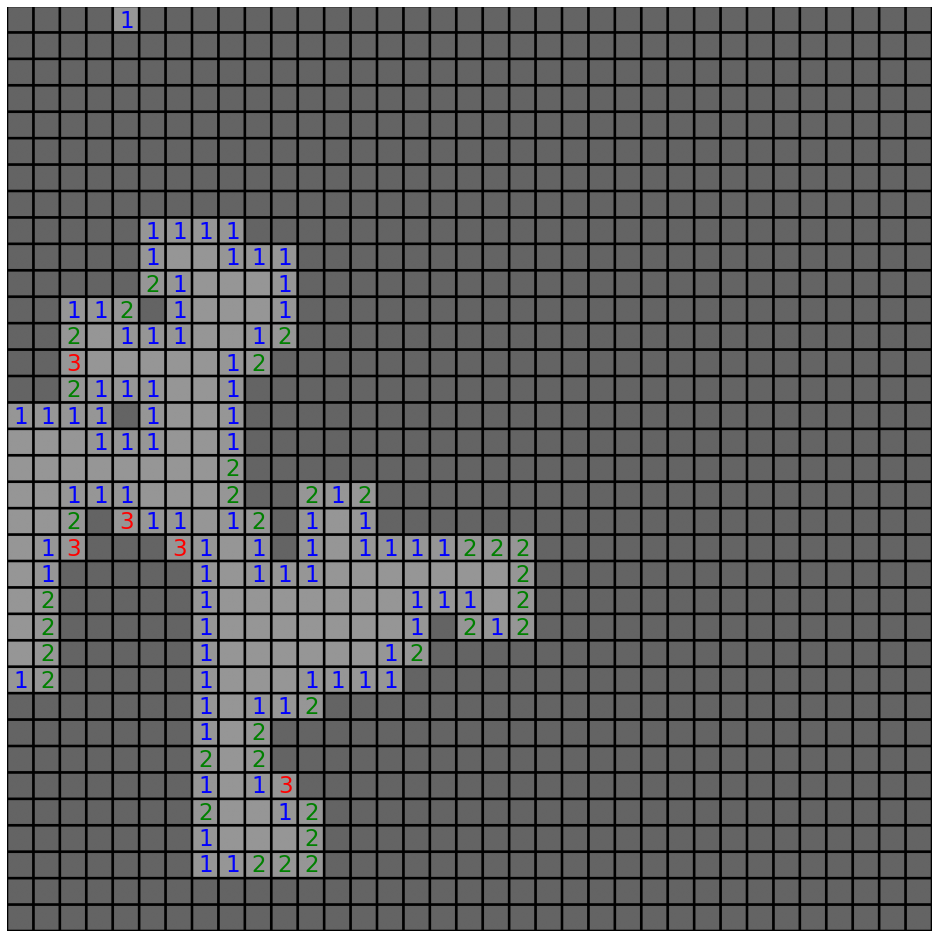

In [ ]:
result_dir = '/content/result_images/'

if os.path.exists(result_dir) is True:
  shutil.rmtree(result_dir)

os.mkdir(result_dir)

for i, field in enumerate(step_field):
  clear_output(wait=1000)
  show_result(field, i, len(step_field), test_minesweeper.free_point, test_minesweeper.mines_coord)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

ep: 1   s.: 160.0   mem.len: 682   eps: 0.5   g_step: 4   av_q: 0.492   av_loss: 0.0
ep: 2   s.: 196.0   mem.len: 1371   eps: 0.5   g_step: 8   av_q: 0.538   av_loss: 0.0533805
ep: 3   s.: 52.0   mem.len: 2101   eps: 0.5   g_step: 12   av_q: 0.447   av_loss: 0.0728034
ep: 4   s.: 157.0   mem.len: 2744   eps: 0.5   g_step: 17   av_q: 0.805   av_loss: 0.0456889
ep: 5   s.: 10.5   mem.len: 3456   eps: 0.5   g_step: 21   av_q: 0.977   av_loss: 0.05894
ep: 6   s.: 27.0   mem.len: 4148   eps: 0.49   g_step: 26   av_q: 1.111   av_loss: 0.0429881
ep: 7   s.: 66.0   mem.len: 4869   eps: 0.49   g_step: 31   av_q: 1.507   av_loss: 0.0433239
ep: 8   s.: 175.5   mem.len: 5537   eps: 0.49   g_step: 35   av_q: 1.701   av_loss: 0.0490275
ep: 9   s.: 70.5   mem.len: 6226   eps: 0.49   g_step: 43   av_q: 1.468   av_loss: 0.0262237
ep: 10   s.: 126.0   mem.len: 6922   eps: 0.49   g_step: 49   av_q: 1.292   av_loss: 0.0345391
ep: 11   s.: 282.0   mem.len: 7581   eps: 0.49   g_step: 55   av_q: 1.794   av_l

### 2 iteration +

continue

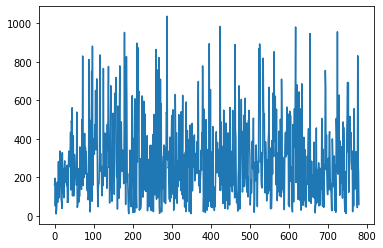

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

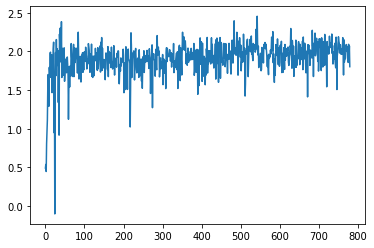

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 16.0 %
200 games - winrate 15.5 %
300 games - winrate 16.0 %
400 games - winrate 16.5 %
500 games - winrate 16.6 %
Total winrate 16.6 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 1.0 %
200 games - winrate 3.5 %
Total winrate 3.5 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

ep: 780   s.: 232.2   mem.len: 677   eps: 0.0   g_step: 23488   av_q: 0.991   av_loss: 0.0
ep: 781   s.: 248.7   mem.len: 1351   eps: 0.0   g_step: 23506   av_q: 1.054   av_loss: 0.0056964
ep: 782   s.: 296.7   mem.len: 1998   eps: 0.0   g_step: 23530   av_q: 1.057   av_loss: 0.0064092
ep: 783   s.: 283.2   mem.len: 2717   eps: 0.0   g_step: 23585   av_q: 1.026   av_loss: 0.0029831
ep: 784   s.: 269.7   mem.len: 3378   eps: 0.0   g_step: 23590   av_q: 1.381   av_loss: 0.0293122
ep: 785   s.: 496.2   mem.len: 3992   eps: 0.0   g_step: 23636   av_q: 1.032   av_loss: 0.0030243
ep: 786   s.: 418.2   mem.len: 4669   eps: 0.0   g_step: 23688   av_q: 1.149   av_loss: 0.0029431
ep: 787   s.: 74.7   mem.len: 5385   eps: 0.0   g_step: 23700   av_q: 1.06   av_loss: 0.0129495
ep: 788   s.: 134.7   mem.len: 6064   eps: 0.0   g_step: 23715   av_q: 0.973   av_loss: 0.00971
ep: 789   s.: 400.2   mem.len: 6699   eps: 0.0   g_step: 23750   av_q: 1.018   av_loss: 0.0040397
ep: 790   s.: 692.7   mem.len: 

### 4 iteration +

continue

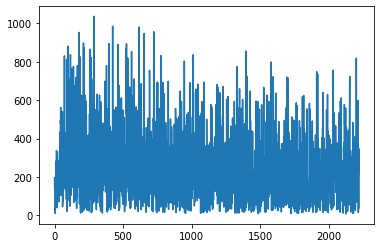

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

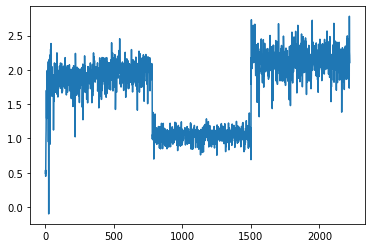

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 34.0 %
200 games - winrate 31.5 %
300 games - winrate 29.67 %
400 games - winrate 28.5 %
500 games - winrate 29.8 %
Total winrate 29.8 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 16.0 %
200 games - winrate 17.5 %
Total winrate 17.5 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

ep: 2220   s.: 220.2   mem.len: 675   eps: 0.0   g_step: 53998   av_q: 1.039   av_loss: 0.0
ep: 2221   s.: 239.7   mem.len: 1387   eps: 0.0   g_step: 54031   av_q: 1.012   av_loss: 0.0035486
ep: 2222   s.: 179.7   mem.len: 2074   eps: 0.0   g_step: 54044   av_q: 1.155   av_loss: 0.0119622
ep: 2223   s.: 271.5   mem.len: 2740   eps: 0.0   g_step: 54068   av_q: 1.05   av_loss: 0.0060977
ep: 2224   s.: 11.7   mem.len: 3469   eps: 0.0   g_step: 54071   av_q: 0.769   av_loss: 0.0528938
ep: 2225   s.: 23.7   mem.len: 4184   eps: 0.0   g_step: 54075   av_q: 0.856   av_loss: 0.039291
ep: 2226   s.: 170.7   mem.len: 4888   eps: 0.0   g_step: 54093   av_q: 1.068   av_loss: 0.0090799
ep: 2227   s.: 212.7   mem.len: 5585   eps: 0.0   g_step: 54126   av_q: 1.031   av_loss: 0.0048667
ep: 2228   s.: 78.0   mem.len: 6296   eps: 0.0   g_step: 54131   av_q: 0.949   av_loss: 0.0318381
ep: 2229   s.: 137.7   mem.len: 6985   eps: 0.0   g_step: 54146   av_q: 1.012   av_loss: 0.0104642
ep: 2230   s.: 65.7   

### 6 iteration +

continue

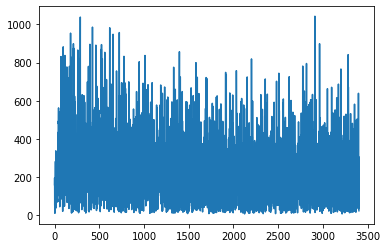

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

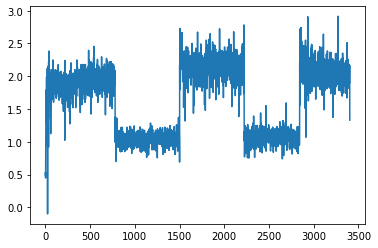

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 33.0 %
200 games - winrate 31.5 %
300 games - winrate 33.67 %
400 games - winrate 36.0 %
500 games - winrate 35.4 %
Total winrate 35.4 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 24.0 %
200 games - winrate 24.5 %
Total winrate 24.5 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True)

ep: 3400   s.: 297.4   mem.len: 693   eps: 0.0   g_step: 75662   av_q: 1.075   av_loss: 0.0
ep: 3401   s.: 143.4   mem.len: 1413   eps: 0.0   g_step: 75673   av_q: 1.043   av_loss: 0.0118786
ep: 3402   s.: 271.0   mem.len: 2125   eps: 0.0   g_step: 75699   av_q: 1.176   av_loss: 0.006948
ep: 3403   s.: 152.2   mem.len: 2792   eps: 0.0   g_step: 75704   av_q: 1.349   av_loss: 0.0341519
ep: 3404   s.: 590.0   mem.len: 3426   eps: 0.0   g_step: 75725   av_q: 1.386   av_loss: 0.0079311
ep: 3405   s.: 185.2   mem.len: 4112   eps: 0.0   g_step: 75740   av_q: 1.367   av_loss: 0.0121032
ep: 3406   s.: 174.2   mem.len: 4794   eps: 0.0   g_step: 75750   av_q: 1.54   av_loss: 0.0172735
ep: 3407   s.: 372.2   mem.len: 5481   eps: 0.0   g_step: 75761   av_q: 1.422   av_loss: 0.0158942
ep: 3408   s.: 372.5   mem.len: 6199   eps: 0.0   g_step: 75792   av_q: 1.522   av_loss: 0.006072
ep: 3409   s.: 609.8   mem.len: 6835   eps: 0.0   g_step: 75813   av_q: 1.514   av_loss: 0.0082616
ep: 3410   s.: 59.8 

### 8 iteration +

continue

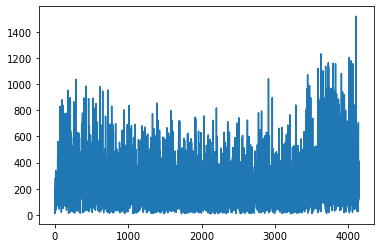

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

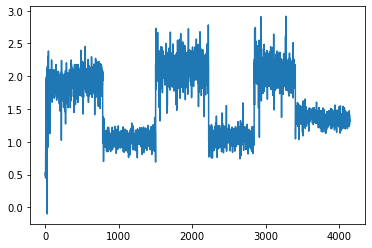

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 21.0 %
200 games - winrate 21.0 %
300 games - winrate 25.67 %
400 games - winrate 25.0 %
500 games - winrate 22.8 %
Total winrate 22.8 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 5.0 %
200 games - winrate 6.5 %
Total winrate 6.5 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True, full_field=True)

ep: 4140   s.: 166.9   mem.len: 9   eps: 0.0   g_step: 93214   av_q: 2.735   av_loss: 0.0
ep: 4141   s.: 67.9   mem.len: 17   eps: 0.0   g_step: 93221   av_q: 2.474   av_loss: 0.0
ep: 4142   s.: 237.3   mem.len: 33   eps: 0.0   g_step: 93236   av_q: 2.645   av_loss: 0.0
ep: 4143   s.: 171.3   mem.len: 45   eps: 0.0   g_step: 93247   av_q: 2.451   av_loss: 0.0
ep: 4144   s.: 837.9   mem.len: 125   eps: 0.0   g_step: 93326   av_q: 2.633   av_loss: 0.0
ep: 4145   s.: 26.1   mem.len: 128   eps: 0.0   g_step: 93328   av_q: 2.319   av_loss: 0.0
ep: 4146   s.: 743.3   mem.len: 188   eps: 0.0   g_step: 93387   av_q: 2.604   av_loss: 0.0
ep: 4147   s.: 444.1   mem.len: 191   eps: 0.0   g_step: 93389   av_q: 2.872   av_loss: 0.0
ep: 4148   s.: 507.9   mem.len: 212   eps: 0.0   g_step: 93409   av_q: 2.831   av_loss: 0.0
ep: 4149   s.: 153.7   mem.len: 216   eps: 0.0   g_step: 93412   av_q: 2.783   av_loss: 0.0
ep: 4150   s.: 369.3   mem.len: 235   eps: 0.0   g_step: 93430   av_q: 2.779   av_loss:

### 9 iteration +

continue

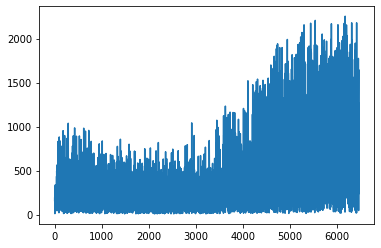

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

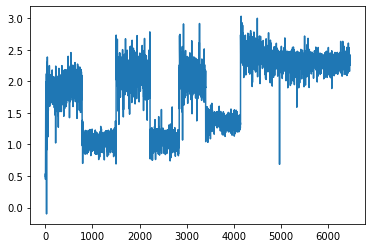

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 53.0 %
200 games - winrate 50.5 %
300 games - winrate 51.0 %
400 games - winrate 49.5 %
500 games - winrate 49.2 %
Total winrate 49.2 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 17.0 %
200 games - winrate 13.5 %
Total winrate 13.5 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True, full_field=True)

ep: 6460   s.: 1739.9   mem.len: 220   eps: 0.0   g_step: 276139   av_q: 2.33   av_loss: 0.0
ep: 6461   s.: 215.3   mem.len: 255   eps: 0.0   g_step: 276173   av_q: 2.334   av_loss: 0.0
ep: 6462   s.: 318.7   mem.len: 295   eps: 0.0   g_step: 276212   av_q: 2.372   av_loss: 0.0
ep: 6463   s.: 246.1   mem.len: 336   eps: 0.0   g_step: 276252   av_q: 2.158   av_loss: 0.0
ep: 6464   s.: 1827.9   mem.len: 541   eps: 0.0   g_step: 276456   av_q: 2.381   av_loss: 0.0
ep: 6465   s.: 2056.7   mem.len: 787   eps: 0.0   g_step: 276701   av_q: 2.294   av_loss: 0.0
ep: 6466   s.: 1178.9   mem.len: 947   eps: 0.0   g_step: 276860   av_q: 2.284   av_loss: 0.0
ep: 6467   s.: 1220.7   mem.len: 1063   eps: 0.0   g_step: 276975   av_q: 2.354   av_loss: 0.0027314
ep: 6468   s.: 1339.5   mem.len: 1225   eps: 0.0   g_step: 277136   av_q: 2.325   av_loss: 0.0051723
ep: 6469   s.: 727.9   mem.len: 1313   eps: 0.0   g_step: 277223   av_q: 2.217   av_loss: 0.0036858
ep: 6470   s.: 1429.7   mem.len: 1511   eps:

### 10 iteration +

continue

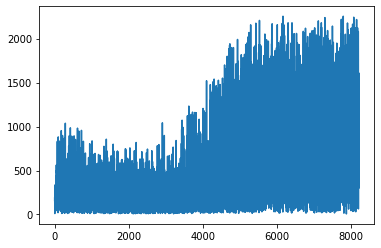

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

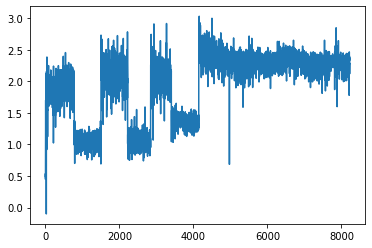

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 53.0 %
200 games - winrate 50.5 %
300 games - winrate 51.0 %
400 games - winrate 49.5 %
500 games - winrate 49.2 %
Total winrate 49.2 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 17.0 %
200 games - winrate 13.5 %
Total winrate 13.5 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True, full_field=True)

ep: 8220   s.: 925.9   mem.len: 78   eps: 0.0   g_step: 453208   av_q: 2.342   av_loss: 0.0
ep: 8221   s.: 584.9   mem.len: 145   eps: 0.0   g_step: 453274   av_q: 2.337   av_loss: 0.0
ep: 8222   s.: 65.7   mem.len: 153   eps: 0.0   g_step: 453281   av_q: 2.262   av_loss: 0.0
ep: 8223   s.: 1220.7   mem.len: 279   eps: 0.0   g_step: 453406   av_q: 2.339   av_loss: 0.0
ep: 8224   s.: 895.1   mem.len: 373   eps: 0.0   g_step: 453499   av_q: 2.313   av_loss: 0.0
ep: 8225   s.: 1394.5   mem.len: 524   eps: 0.0   g_step: 453649   av_q: 2.313   av_loss: 0.0
ep: 8226   s.: 1203.1   mem.len: 677   eps: 0.0   g_step: 453801   av_q: 2.315   av_loss: 0.0
ep: 8227   s.: 2157.9   mem.len: 995   eps: 0.0   g_step: 454118   av_q: 2.217   av_loss: 0.0
ep: 8228   s.: 184.5   mem.len: 1016   eps: 0.0   g_step: 454138   av_q: 2.283   av_loss: 0.0044963
ep: 8229   s.: 752.1   mem.len: 1103   eps: 0.0   g_step: 454224   av_q: 2.319   av_loss: 0.0065624
ep: 8230   s.: 873.1   mem.len: 1226   eps: 0.0   g_st

### 11 iteration +

continue

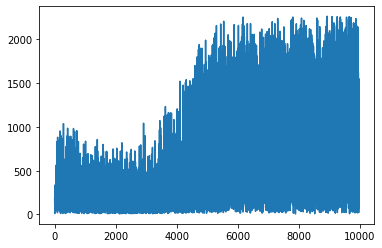

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

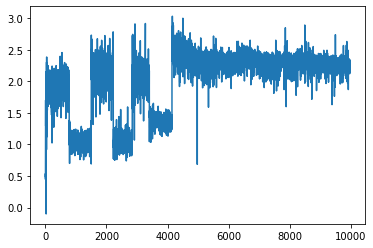

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 59.0 %
200 games - winrate 58.5 %
300 games - winrate 61.0 %
400 games - winrate 58.25 %
500 games - winrate 56.2 %
Total winrate 56.2 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 26.0 %
200 games - winrate 22.0 %
Total winrate 22.0 %


In [ ]:
playfield_h = 15
playfield_w = 15
mines_count = 37

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 16.0 %
200 games - winrate 16.0 %
300 games - winrate 16.67 %
Total winrate 16.666666666666668 %


In [ ]:
playfield_h = 9
playfield_w = 9
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 81.0 %
200 games - winrate 77.5 %
300 games - winrate 77.0 %
Total winrate 77.0 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 35

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 46.0 %
200 games - winrate 44.5 %
300 games - winrate 43.67 %
Total winrate 43.666666666666664 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True, full_field=True)

ep: 9960   s.: 439.7   mem.len: 40   eps: 0.0   g_step: 646791   av_q: 2.347   av_loss: 0.0
ep: 9961   s.: 1627.7   mem.len: 275   eps: 0.0   g_step: 647025   av_q: 2.269   av_loss: 0.0
ep: 9962   s.: 523.3   mem.len: 328   eps: 0.0   g_step: 647077   av_q: 2.248   av_loss: 0.0
ep: 9963   s.: 138.3   mem.len: 356   eps: 0.0   g_step: 647104   av_q: 2.04   av_loss: 0.0
ep: 9964   s.: 567.3   mem.len: 436   eps: 0.0   g_step: 647183   av_q: 2.298   av_loss: 0.0
ep: 9965   s.: 1638.7   mem.len: 664   eps: 0.0   g_step: 647410   av_q: 2.284   av_loss: 0.0
ep: 9966   s.: 1035.9   mem.len: 772   eps: 0.0   g_step: 647517   av_q: 2.321   av_loss: 0.0
ep: 9967   s.: 103.1   mem.len: 790   eps: 0.0   g_step: 647534   av_q: 2.253   av_loss: 0.0
ep: 9968   s.: 963.3   mem.len: 903   eps: 0.0   g_step: 647646   av_q: 2.295   av_loss: 0.0
ep: 9969   s.: 397.9   mem.len: 940   eps: 0.0   g_step: 647682   av_q: 2.287   av_loss: 0.0
ep: 9970   s.: 1354.9   mem.len: 1035   eps: 0.0   g_step: 647776   a

### 12 iteration +

continue

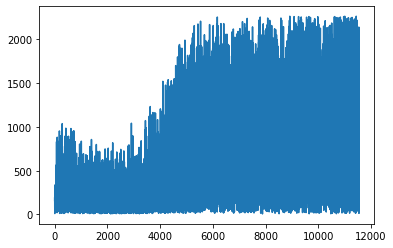

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

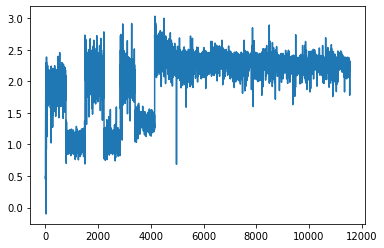

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 63.0 %
200 games - winrate 55.5 %
300 games - winrate 57.0 %
400 games - winrate 58.5 %
500 games - winrate 58.8 %
Total winrate 58.8 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 26.0 %
200 games - winrate 23.5 %
Total winrate 23.5 %


In [ ]:
playfield_h = 15
playfield_w = 15
mines_count = 37

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 23.0 %
200 games - winrate 19.0 %
300 games - winrate 17.33 %
Total winrate 17.333333333333332 %


In [ ]:
playfield_h = 9
playfield_w = 9
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 77.0 %
200 games - winrate 75.5 %
300 games - winrate 76.67 %
Total winrate 76.66666666666667 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 35

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 46.0 %
200 games - winrate 45.0 %
300 games - winrate 44.67 %
Total winrate 44.666666666666664 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True, full_field=True)

ep: 11540   s.: 1781.7   mem.len: 229   eps: 0.0   g_step: 837261   av_q: 2.268   av_loss: 0.0
ep: 11541   s.: 945.7   mem.len: 290   eps: 0.0   g_step: 837321   av_q: 2.309   av_loss: 0.0
ep: 11542   s.: 1654.1   mem.len: 488   eps: 0.0   g_step: 837518   av_q: 2.261   av_loss: 0.0
ep: 11543   s.: 116.3   mem.len: 497   eps: 0.0   g_step: 837526   av_q: 2.336   av_loss: 0.0
ep: 11544   s.: 2087.5   mem.len: 775   eps: 0.0   g_step: 837803   av_q: 2.283   av_loss: 0.0
ep: 11545   s.: 1266.9   mem.len: 930   eps: 0.0   g_step: 837957   av_q: 2.324   av_loss: 0.0
ep: 11546   s.: 2217.3   mem.len: 1287   eps: 0.0   g_step: 838313   av_q: 2.173   av_loss: 0.0021846
ep: 11547   s.: 1321.9   mem.len: 1489   eps: 0.0   g_step: 838514   av_q: 2.251   av_loss: 0.0020408
ep: 11548   s.: 1156.9   mem.len: 1549   eps: 0.0   g_step: 838573   av_q: 2.309   av_loss: 0.0028176
ep: 11549   s.: 1000.7   mem.len: 1627   eps: 0.0   g_step: 838650   av_q: 2.277   av_loss: 0.0033167
ep: 11550   s.: 2076.5  

### 13 iteration +

continue

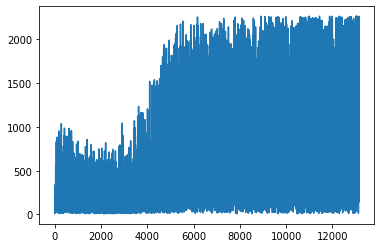

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

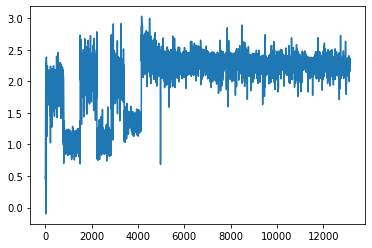

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 54.0 %
200 games - winrate 59.5 %
300 games - winrate 60.33 %
400 games - winrate 59.0 %
500 games - winrate 57.4 %
Total winrate 57.4 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 28.0 %
200 games - winrate 31.5 %
Total winrate 31.5 %


In [ ]:
playfield_h = 15
playfield_w = 15
mines_count = 37

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 14.0 %
200 games - winrate 18.0 %
300 games - winrate 19.0 %
Total winrate 19.0 %


In [ ]:
playfield_h = 9
playfield_w = 9
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 83.0 %
200 games - winrate 80.5 %
300 games - winrate 78.0 %
Total winrate 78.0 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 35

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 55.0 %
200 games - winrate 47.5 %
300 games - winrate 47.67 %
Total winrate 47.666666666666664 %


In [ ]:
playfield_h = 35
playfield_w = 35
mines_count = 195

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
train_minesweeper(episodes, episode_start, epsilon, global_step, advanced=True, full_field=True)

ep: 13140   s.: 2078.7   mem.len: 352   eps: 0.0   g_step: 1028115   av_q: 2.23   av_loss: 0.0
ep: 13141   s.: 441.9   mem.len: 373   eps: 0.0   g_step: 1028135   av_q: 2.272   av_loss: 0.0
ep: 13142   s.: 952.3   mem.len: 503   eps: 0.0   g_step: 1028264   av_q: 2.25   av_loss: 0.0
ep: 13143   s.: 1948.9   mem.len: 805   eps: 0.0   g_step: 1028565   av_q: 2.243   av_loss: 0.0
ep: 13144   s.: 556.3   mem.len: 885   eps: 0.0   g_step: 1028644   av_q: 2.263   av_loss: 0.0
ep: 13145   s.: 1068.9   mem.len: 1023   eps: 0.0   g_step: 1028781   av_q: 2.263   av_loss: 0.0005413
ep: 13146   s.: 1029.3   mem.len: 1145   eps: 0.0   g_step: 1028902   av_q: 2.346   av_loss: 0.0026835
ep: 13147   s.: 952.3   mem.len: 1272   eps: 0.0   g_step: 1029028   av_q: 2.225   av_loss: 0.0021298
ep: 13148   s.: 1365.9   mem.len: 1434   eps: 0.0   g_step: 1029189   av_q: 2.313   av_loss: 0.0037037
ep: 13149   s.: 1130.5   mem.len: 1586   eps: 0.0   g_step: 1029340   av_q: 2.273   av_loss: 0.0033282
ep: 13150  

## Results

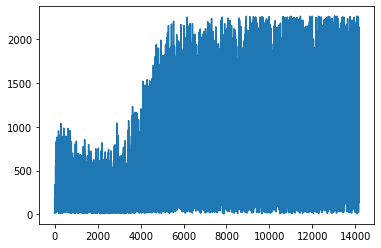

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/scores.npy')

plt.plot(scores_history)
plt.show()

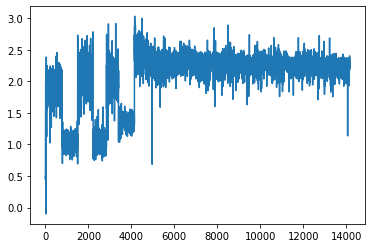

In [ ]:
scores_history = np.load('/content/drive/MyDrive/diplom/35x35/average_scores.npy')

plt.plot(scores_history)
plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/diplom/35x35/'
episode_start, global_step = np.load(os.path.join(checkpoint_dir, 'step_info.npy')).tolist()
scores = np.load(os.path.join(checkpoint_dir, 'scores.npy')).tolist()
average_scores = np.load(os.path.join(checkpoint_dir, 'average_scores.npy')).tolist()
dicision_field = 35
playfield_h = 35
playfield_w = 35
mines_count = 195
scale_factor = 0
epsilon = 0.0
episodes = 1000000

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)
agent = Agent(dicision_field, epsilon)

In [ ]:
playfield_h = 8
playfield_w = 8
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 500

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 62.0 %
200 games - winrate 60.5 %
300 games - winrate 58.33 %
400 games - winrate 57.5 %
500 games - winrate 59.0 %
Total winrate 59.0 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 40

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 200

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 22.0 %
200 games - winrate 20.0 %
Total winrate 20.0 %


In [ ]:
playfield_h = 15
playfield_w = 15
mines_count = 37

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 18.0 %
200 games - winrate 20.0 %
300 games - winrate 18.0 %
Total winrate 18.0 %


In [ ]:
playfield_h = 9
playfield_w = 9
mines_count = 10

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 80.0 %
200 games - winrate 78.0 %
300 games - winrate 79.67 %
Total winrate 79.66666666666667 %


In [ ]:
playfield_h = 16
playfield_w = 16
mines_count = 35

test_minesweeper = Minesweeper(mines_count, playfield_h, playfield_w)

In [ ]:
# Проверим winrate, когда сапер открыл все свободные клетки
scale_factor = 0
score = 0
n = 300

for i in range(1, n+1):
  curr_result = check_winrate_lower_size()
  score += curr_result
  if i % 100 == 0:
    print(f'{i} games - winrate {round(score*100/i, 2)} %')

print(f'Total winrate {score*100/n} %')

100 games - winrate 50.0 %
200 games - winrate 52.0 %
300 games - winrate 50.33 %
Total winrate 50.333333333333336 %
